# Pseudo Double Source Plane Lenses (PDSPL) Forecast
### Author: Paras Sharma

This notebook simulates pseudo double source plane lenses and mainly tries to answer the following questions:

Given the number of expected lenses to be of order 100'000, how near-identical are pairs of lenses to look like, such that they can be used as a defacto double source plane lenses?

1. Perform a forecast of lenses with SLSim
2. Assess how close nearest-pairs of lenses are look-alike and how much scatter they introduce in their estimated mass.
3. Perform a forecast how pseudo double source plane lenses can constrain cosmology pretending them to be double source plane lenses with increased measurement uncertainties. You can use hierArc to run the forecast.


In this notebook we figure out constratins on the following parameters for two deflectors such that they can be used as pseudo double source plane lenses:
- $ΔM$ - the difference in mass between the two deflectors
- $Δz$ - the difference in redshift between the two deflectors
- $Δm$ - the difference in magnitude between the two deflectors for different bands
- $Δ\text{size}$ - the difference in size between the two deflectors.


In [122]:
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.lens_pop import LensPop
from slsim.Plots.lens_plots import LensingPlots
import numpy as np
import corner
import slsim.Pipelines as pipelines
import slsim.Sources as sources
import slsim.Deflectors as deflectors
from slsim.lens import Lens
from slsim.image_simulation import lens_image, rgb_image_from_image_list
from slsim.Util.param_util import gaussian_psf
# import standard python modules
import copy
import matplotlib.patches as mpatches
from itertools import combinations
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

# import lenstronomy and hierArc modules
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam
from hierarc.Sampling.mcmc_sampling import MCMCSampler

from hierarc.Likelihood.LensLikelihood.double_source_plane import (
    beta_double_source_plane,
    beta2theta_e_ratio,
)


## Criterion for near-identical lenses

We want $\frac{\theta_{E1}}{\theta_{E2}}$ to be nearly the same as $\frac{\theta_{E1, virtual}}{\theta_{E2}}$ or $\frac{\theta_{E1}}{\theta_{E2, virtual}}$ for these two lenses to be considered a PDSPL.

Now we want to find $|Δz_{D}|$ and $|Δσ_{D}|$ such that the above condition is satisfied.

$$Q = \left| \frac{\theta_{E1}}{\theta_{E2}} - \frac{\theta_{E1, virtual}}{\theta_{E2}} \right|^2 + \left| \frac{\theta_{E1}}{\theta_{E2}} - \frac{\theta_{E1}}{\theta_{E2, virtual}} \right|^2$$

Minimizing $Q$ gives us the best pair of lenses that are near-identical and can be used as a pseudo double source plane lens.

In [7]:
def quantity_Q(theta_E1, theta_E2, theta_E1_virtual, theta_E2_virtual):
    """
    Calculate the quantity Q as defined in the paper.
    Q = (theta_E1 * theta_E2) / (theta_E1_virtual * theta_E2_virtual)
    """
    first = np.abs(theta_E1 / theta_E2 - theta_E1_virtual / theta_E2)
    second = np.abs(theta_E1 / theta_E2 - theta_E1 / theta_E2_virtual)

    return first**2 + second**2

## Generate population of sources and (potential) deflectors

In [53]:
# define a cosmology
cosmology = "FwCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
kwargs_cosmo_true = {"h0": 70, "om": 0.3, "w": -1}  # cosmological model of the forecast

# create astropy.cosmology instance of input cosmology
cosmo_param = CosmoParam(cosmology=cosmology)
cosmo = cosmo_param.cosmo(kwargs_cosmo_true)

# define a sky area
sky_area = Quantity(value=2, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"band": "g", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "g", "band_max": 28, "z_min": 0.1, "z_max": 5.0}

# Generate galaxy population using skypy pipeline.
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None, sky_area=sky_area, filters=None, cosmo=cosmo
)

# Initiate deflector population class.
lens_galaxies = deflectors.AllLensGalaxies(
    red_galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    blue_galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light=None,
    cosmo=cosmo,
    sky_area=sky_area,
)

# Initiate source population class.
source_galaxies = sources.Galaxies(
    galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_source_cut,
    cosmo=cosmo,
    sky_area=sky_area,
    catalog_type="skypy",
)

# make galaxy-galaxy population class using LensPop
gg_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_galaxies,
    cosmo=cosmo,
    sky_area=sky_area,
)

# make lensplot class for extracting rgb images
gg_plot = LensingPlots(gg_lens_pop, num_pix=100, coadd_years=10)

print(f"LensPop initialized. Potential deflectors: {gg_lens_pop.deflector_number} ; Potential sources: {gg_lens_pop.source_number}");

/Users/paras/Library/CloudStorage/GoogleDrive-paras.sharma@stonybrook.edu/My Drive/SL Research/codes/repos/self/slsim/slsim/Deflectors/all_lens_galaxies.py:54: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  red_galaxy_list = catalog_with_angular_size_in_arcsec(
/Users/paras/Library/CloudStorage/GoogleDrive-paras.sharma@stonybrook.edu/My Drive/SL Research/codes/repos/self/slsim/slsim/Deflectors/all_lens_galaxies.py:57: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  blue_galaxy_list = catalog_with_angular_size_in_arcsec(


LensPop initialized. Potential deflectors: 703880 ; Potential sources: 950104


## Draw Lenses and Compute DSPL properties

In [54]:
# kwargs_lens_cut = {"min_image_separation": 1, "max_image_separation": 10}
kwargs_lens_cut = {}
selected_lenses = gg_lens_pop.draw_population(
    kwargs_lens_cuts=kwargs_lens_cut,
)
print(f"Number of selected lenses: {len(selected_lenses)}")

Number of selected lenses: 798


In [ ]:
# make pairs of deflector and source galaxies and find the measured ratios of the Einstein radius
lens_pairings = combinations(
    selected_lenses, 2
)  # all possible pairs of lenses
lens_pairings = list(lens_pairings)

pairing_parameters = {
    "lens_pairings": [],
    "z_D1": [],
    "z_D2": [],
    "z_S1": [],
    "z_S2": [],
    "theta_E1": [],
    "theta_E2": [],
    "theta_E_ratio": [],
    "theta_E1_virtual": [], # virtual Einstein radius of lens1 for source2
    "theta_E2_virtual": [], # virtual Einstein radius of lens2 for source1
    "theta_E1_by_theta_E2_virtual": [], # ratio of virtual Einstein radii
    "theta_E1_virtual_by_theta_E2": [], # ratio of virtual Einstein radii
    "sigma_v_D1": [], # velocity dispersion of deflector 1
    "sigma_v_D2": [], # velocity dispersion of deflector 2
    "beta_DSPL_D1": [], # beta double source plane i.e., ratio of distances, assuming D1
    "beta_DSPL_D2": [], # beta double source plane i.e., ratio of distances, assuming D2
    "delta_z_D": [], # difference in redshift of deflector 1 and 2
    "delta_sigma_v_D": [], # difference in velocity dispersions
    "abs_delta_z_D": [], # absolute difference in redshift of deflector 1 and 2
    "abs_delta_sigma_v_D": [], # absolute difference in velocity dispersions
    "Q": [], # quantity Q as defined above
}

for lens_pair in lens_pairings:
    lens1 = lens_pair[0]
    lens2 = lens_pair[1]

    source1 = lens1.source(index = 0)
    source2 = lens2.source(index = 0)

    deflector1 = lens1.deflector
    deflector2 = lens2.deflector

    # get the deflector and source redshifts
    z_D1 = lens1.deflector_redshift
    z_D2 = lens2.deflector_redshift
    z_S1 = source1.redshift
    z_S2 = source2.redshift

    # get the Einstein radii
    theta_E1 = lens1._einstein_radius(source1)
    theta_E2 = lens2._einstein_radius(source2)

    # get the velocity dispersions
    sigma_v_D1 = deflector1.velocity_dispersion()
    sigma_v_D2 = deflector2.velocity_dispersion()

    # calculate the ratio of the Einstein radii
    theta_E_ratio = theta_E1 / theta_E2

    # calculate the virtual Einstein radii
    theta_E1_virtual = lens2._einstein_radius(source1) # virtual Einstein radius of lens2 for source1
    theta_E2_virtual = lens1._einstein_radius(source2) # virtual Einstein radius of lens1 for source2

    # calculate the ratio of the virtual Einstein radii
    theta_E1_by_theta_E2_virtual = theta_E1 / theta_E2_virtual
    theta_E1_virtual_by_theta_E2 = theta_E1_virtual / theta_E2

    # calculate the beta double source plane
    if z_D1 < np.min([z_S1, z_S2]) and z_D2 < np.min([z_S1, z_S2]):
        beta_DSPL_D1 = beta_double_source_plane(
            z_D1, z_S1, z_S2, cosmo
        )
        beta_DSPL_D2 = beta_double_source_plane(
            z_D2, z_S1, z_S2, cosmo
        )
    elif z_D1 < np.min([z_S1, z_S2]) and z_D2 > np.max([z_S1, z_S2]):
        beta_DSPL_D1 = beta_double_source_plane(
            z_D1, z_S1, z_S2, cosmo
        )
        beta_DSPL_D2 = np.nan
    elif z_D1 > np.max([z_S1, z_S2]) and z_D2 < np.min([z_S1, z_S2]):
        beta_DSPL_D1 = np.nan
        beta_DSPL_D2 = beta_double_source_plane(
            z_D2, z_S1, z_S2, cosmo
        )
    else:
        beta_DSPL_D1 = np.nan
        beta_DSPL_D2 = np.nan

    # calculate the difference in redshift and velocity dispersion
    delta_z_D = z_D1 - z_D2
    delta_sigma_v_D = sigma_v_D1 - sigma_v_D2
    abs_delta_z_D = np.abs(delta_z_D)
    abs_delta_sigma_v_D = np.abs(delta_sigma_v_D)

    # calculate the quantity Q
    Q = quantity_Q(
        theta_E1, theta_E2, theta_E1_virtual, theta_E2_virtual
    )

    # append the values to the pairing_parameters dictionary
    pairing_parameters["lens_pairings"].append(lens_pair)
    pairing_parameters["z_D1"].append(z_D1)
    pairing_parameters["z_D2"].append(z_D2)
    pairing_parameters["z_S1"].append(z_S1)
    pairing_parameters["z_S2"].append(z_S2)
    pairing_parameters["theta_E1"].append(theta_E1)
    pairing_parameters["theta_E2"].append(theta_E2)
    pairing_parameters["theta_E_ratio"].append(theta_E_ratio)
    pairing_parameters["theta_E1_virtual"].append(theta_E1_virtual)
    pairing_parameters["theta_E2_virtual"].append(theta_E2_virtual)
    pairing_parameters["theta_E1_by_theta_E2_virtual"].append(
        theta_E1_by_theta_E2_virtual
    )
    pairing_parameters["theta_E1_virtual_by_theta_E2"].append(
        theta_E1_virtual_by_theta_E2
    )
    pairing_parameters["sigma_v_D1"].append(sigma_v_D1)
    pairing_parameters["sigma_v_D2"].append(sigma_v_D2)
    pairing_parameters["beta_DSPL_D1"].append(beta_DSPL_D1)
    pairing_parameters["beta_DSPL_D2"].append(beta_DSPL_D2)
    pairing_parameters["delta_z_D"].append(delta_z_D)
    pairing_parameters["delta_sigma_v_D"].append(delta_sigma_v_D)
    pairing_parameters["abs_delta_z_D"].append(abs_delta_z_D)
    pairing_parameters["abs_delta_sigma_v_D"].append(abs_delta_sigma_v_D)
    pairing_parameters["Q"].append(Q)
    pairing_parameters["minus_log10_Q"].append(-np.log10(Q))
# convert the pairing_parameters dictionary to a numpy array
pairing_parameters = {
    key: np.array(value) for key, value in pairing_parameters.items()
}

/var/folders/4r/jq9w4fy92y9_bqzvdfk2d5h40000gn/T/ipykernel_63079/81123837.py:63: RuntimeWarning: divide by zero encountered in scalar divide
  theta_E1_by_theta_E2_virtual = theta_E1 / theta_E2_virtual
/var/folders/4r/jq9w4fy92y9_bqzvdfk2d5h40000gn/T/ipykernel_63079/3197838313.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  second = np.abs(theta_E1 / theta_E2 - theta_E1 / theta_E2_virtual)


Text(0.5, 0.95, 'Initial Pairing Parameters')

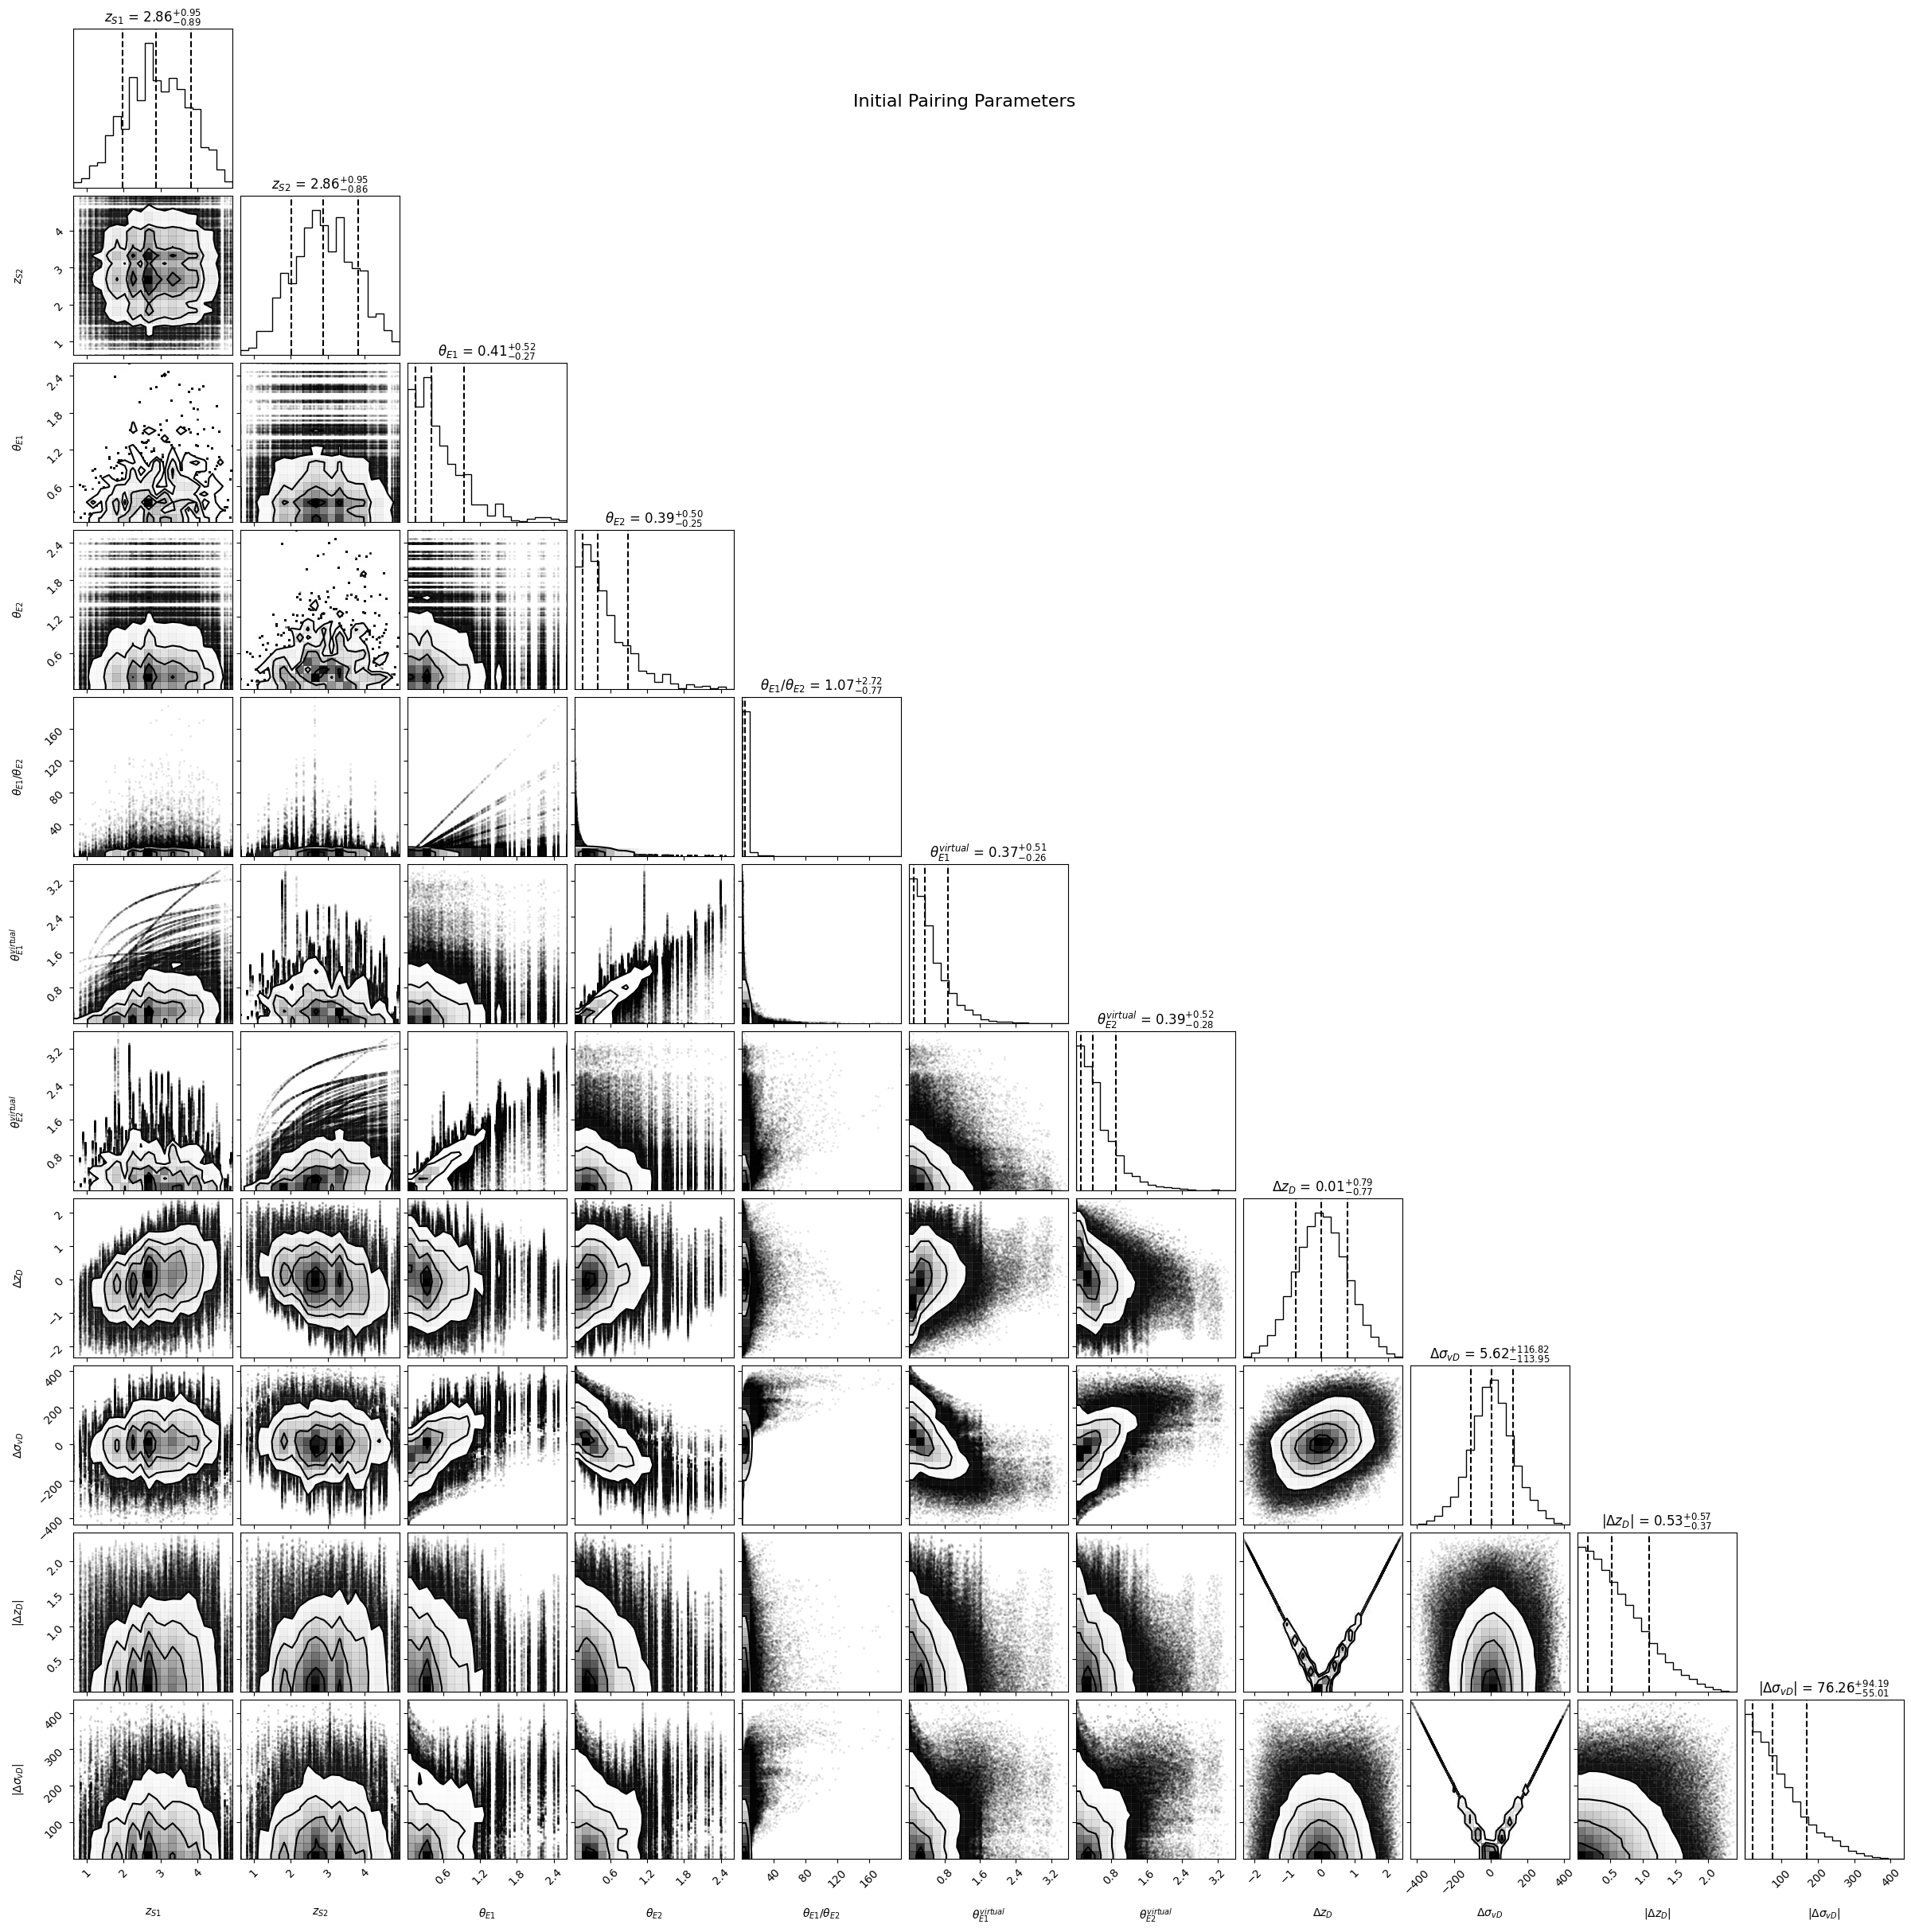

In [56]:
# make a corner plot for all the parameters

# Define the exact order of parameters we want to plot:
keys = [
    "z_S1", "z_S2",
    "theta_E1", "theta_E2", "theta_E_ratio",
    "theta_E1_virtual", "theta_E2_virtual",
    # "beta_DSPL_D1", "beta_DSPL_D2",
    "delta_z_D", "delta_sigma_v_D",
    "abs_delta_z_D", "abs_delta_sigma_v_D",
]

latex_labels = {
    "z_S1": r"$z_{S1}$",
    "z_S2": r"$z_{S2}$",
    "theta_E1": r"$\theta_{E1}$",
    "theta_E2": r"$\theta_{E2}$",
    "theta_E_ratio": r"$\theta_{E1}/\theta_{E2}$",
    "theta_E1_virtual": r"$\theta_{E1}^{virtual}$",
    "theta_E2_virtual": r"$\theta_{E2}^{virtual}$",
    # "beta_DSPL_D1": r"$\beta_{DSPL D1}$",
    # "beta_DSPL_D2": r"$\beta_{DSPL D2}$",
    "delta_z_D": r"$\Delta z_D$",
    "delta_sigma_v_D": r"$\Delta \sigma_{vD}$",
    "abs_delta_z_D": r"$|\Delta z_D|$",
    "abs_delta_sigma_v_D": r"$|\Delta \sigma_{vD}|$",
}

# Stack into an (n_samples, n_keys) array:
data = np.column_stack([pairing_parameters[k] for k in keys])

# Now call corner with the array:
fig = corner.corner(
    data,
    labels=[latex_labels[k] for k in keys],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    quantiles=[0.16, 0.5, 0.84],
)
fig.suptitle(
    "Initial Pairing Parameters",
    fontsize=16,
    y=0.95,
)

## Criterion for near-identical lenses

We want $\frac{\theta_{E1}}{\theta_{E2}}$ to be nearly the same as $\frac{\theta_{E1, virtual}}{\theta_{E2}}$ or $\frac{\theta_{E1}}{\theta_{E2, virtual}}$ for these two lenses to be considered a PDSPL.

Now we want to find $|Δz_{D}|$ and $|Δσ_{D}|$ such that the above condition is satisfied.

$$Q = \left| \frac{\theta_{E1}}{\theta_{E2}} - \frac{\theta_{E1, virtual}}{\theta_{E2}} \right|^2 + \left| \frac{\theta_{E1}}{\theta_{E2}} - \frac{\theta_{E1}}{\theta_{E2, virtual}} \right|^2$$

Minimizing $Q$ (Or maximizing $-\log(Q)$) gives us the best pair of lenses that are near-identical and can be used as a pseudo double source plane lens.

/var/folders/4r/jq9w4fy92y9_bqzvdfk2d5h40000gn/T/ipykernel_63079/879157738.py:27: RuntimeWarning: divide by zero encountered in log10
  to_plot = -np.log10(Q_hist.T) # transpose to match the x and y axes


<a list of 660 text.Text objects>

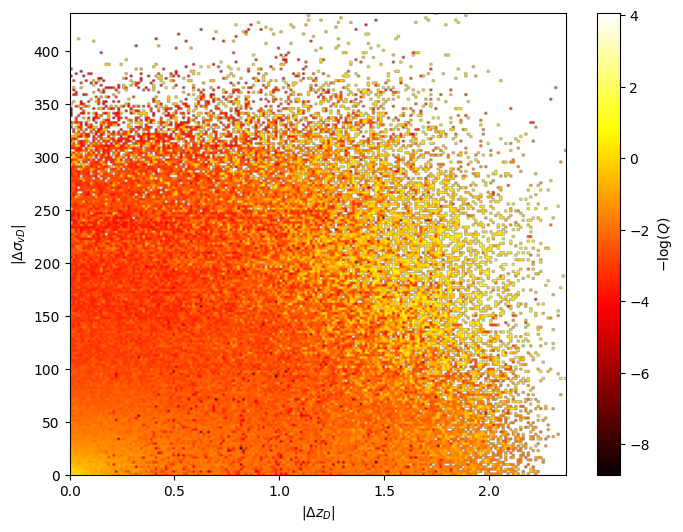

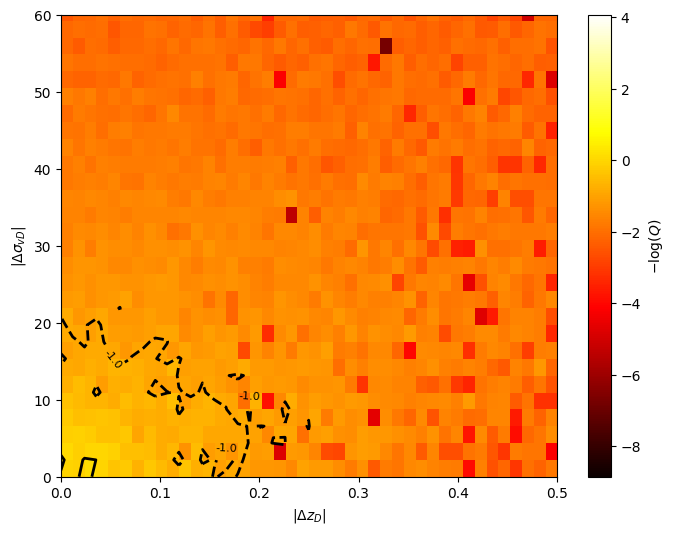

In [ ]:
## Make a heatmap of the Q parameter against $Δz_D$ and $Δσ_{vD}$
# mask for infs or nans
mask = np.isfinite(pairing_parameters["Q"]) & np.isfinite(pairing_parameters["abs_delta_z_D"]) & np.isfinite(pairing_parameters["abs_delta_sigma_v_D"])
filtered_pairing_parameters = {
    key: value[mask] for key, value in pairing_parameters.items()
}

abs_delta_z_D_bins = np.linspace(
    np.min(filtered_pairing_parameters["abs_delta_z_D"]),
    np.max(filtered_pairing_parameters["abs_delta_z_D"]),
    200,
)
abs_delta_sigma_v_D_bins = np.linspace(
    np.min(filtered_pairing_parameters["abs_delta_sigma_v_D"]),
    np.max(filtered_pairing_parameters["abs_delta_sigma_v_D"]),
    200,
)

# Create a 2D histogram of Q values
Q_hist, xedges, yedges = np.histogram2d(
    filtered_pairing_parameters["abs_delta_z_D"],
    filtered_pairing_parameters["abs_delta_sigma_v_D"],
    bins=[abs_delta_z_D_bins, abs_delta_sigma_v_D_bins],
    weights=filtered_pairing_parameters["Q"],
)

to_plot = -np.log10(Q_hist.T) # transpose to match the x and y axes

# plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(
    to_plot,
    origin="lower",
    aspect="auto",
    extent=[
        xedges[0],
        xedges[-1],
        yedges[0],
        yedges[-1],
    ],
    cmap="hot",
)
plt.colorbar(label="$-\\log(Q)$")
plt.xlabel(r"$|\Delta z_D|$")
plt.ylabel(r"$|\Delta \sigma_{vD}|$")


# contours
# plt.contour(
#     xedges[:-1],
#     yedges[:-1],
#     to_plot,
#     levels=range(-10, 0, 1),
#     colors="white",
#     linewidths=0.5,
# )

### Zoom into the region with |Δz_D| < 0.5 and |Δσ_{vD}| < 60 km/s
fig, ax = plt.subplots(figsize=(8, 6))
plt.imshow(
    to_plot,
    origin="lower",
    aspect="auto",
    extent=[
        xedges[0],
        xedges[-1],
        yedges[0],
        yedges[-1],
    ],
    cmap="hot",
    interpolation="nearest",
)
plt.colorbar(label="$-\\log(Q)$")
plt.xlabel(r"$|\Delta z_D|$")
plt.ylabel(r"$|\Delta \sigma_{vD}|$")
plt.xlim(0, 0.5)
plt.ylim(0, 60)
cs = plt.contour(
    xedges[:-1],
    yedges[:-1],
    to_plot,
    levels=[ -1, 0],
    colors="k",
    linewidths=2,
)
plt.clabel(
    cs,
    inline=True,
    fontsize=8,
    fmt="%1.1f",
    colors="k",
    use_clabeltext=True,
)

Text(0.5, 1.0, 'Histogram of $-\\log(Q)$ values for all lenses')

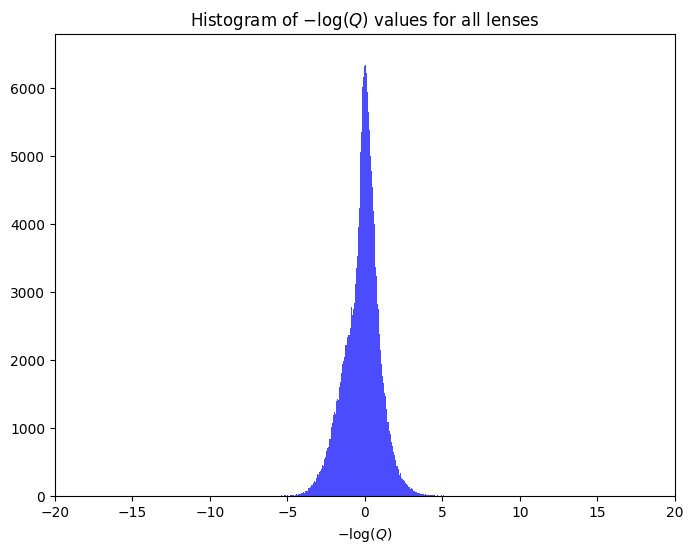

In [101]:
#histogram of Q values all range of |Δz_D| and |Δσ_{vD}|
plt.figure(figsize=(8, 6))
to_plot_hist = -np.log10(filtered_pairing_parameters["Q"])
plt.hist(
    to_plot_hist,
    bins=1000,
    color="blue",
    alpha=0.7,
);
# plt.xscale("log")
# plt.yscale("log")
plt.xlim(-20, 20)
plt.xlabel("$-\\log(Q)$")
plt.title("Histogram of $-\\log(Q)$ values for all lenses")

Text(0.5, 1.0, 'Histogram of $-\\log(Q)$ values for lenses with |Δz_D| < 0.5 and |Δσ_{vD}| < 60 km/s')

<Figure size 800x600 with 0 Axes>

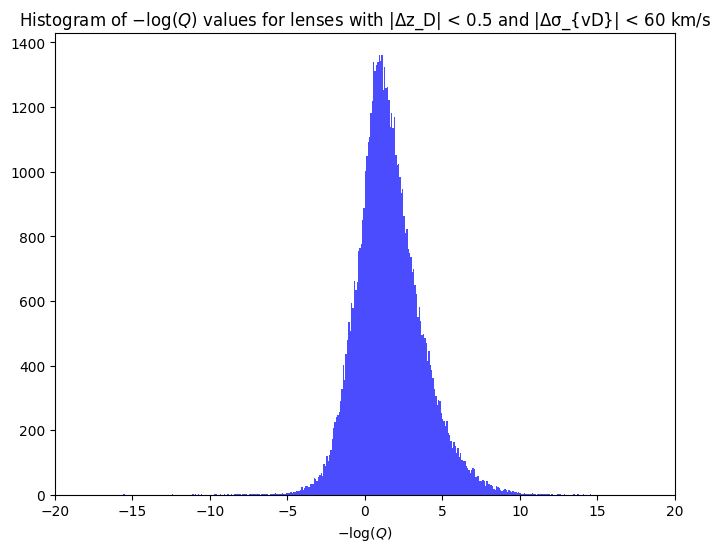

In [102]:
#histogram of Q values for |Δz_D| < 0.5 and |Δσ_{vD}| < 60 km/s
plt.figure(figsize=(8, 6))
to_plot_hist = -np.log(filtered_pairing_parameters["Q"])
mask = (
    filtered_pairing_parameters["abs_delta_z_D"] < 0.5
) & (filtered_pairing_parameters["abs_delta_sigma_v_D"] < 60)
to_plot_hist = to_plot_hist[mask]
plt.figure(figsize=(8, 6))
plt.hist(
    to_plot_hist,
    bins=1000,
    color="blue",
    alpha=0.7,
);
# plt.xscale("log")
# plt.yscale("log")
plt.xlim(-20, 20)
plt.xlabel("$-\\log(Q)$")
plt.title("Histogram of $-\\log(Q)$ values for lenses with |Δz_D| < 0.5 and |Δσ_{vD}| < 60 km/s")

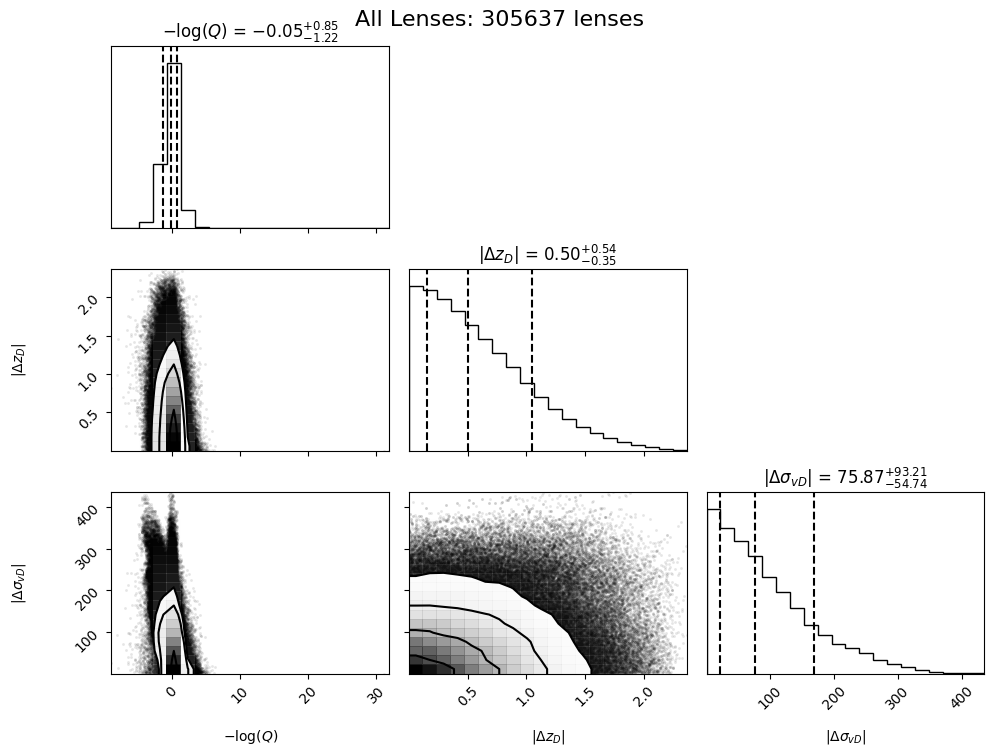

In [113]:
# make corner for -log(Q) vs abs_delta_z_D and abs_delta_sigma_v_D
keys = [
    "minus_log10_Q",
    "abs_delta_z_D",
    "abs_delta_sigma_v_D",
]
latex_labels = {
    "minus_log10_Q": r"$-\log(Q)$",
    "abs_delta_z_D": r"$|\Delta z_D|$",
    "abs_delta_sigma_v_D": r"$|\Delta \sigma_{vD}|$",
}

# mask for infs or nans
mask = np.isfinite(pairing_parameters["Q"]) & np.isfinite(pairing_parameters["abs_delta_z_D"]) & np.isfinite(pairing_parameters["abs_delta_sigma_v_D"])
filtered_pairing_parameters = {
    key: value[mask] for key, value in pairing_parameters.items()
}
# Stack into an (n_samples, n_keys) array:
data = np.column_stack([filtered_pairing_parameters[k] for k in keys])
# Now call corner with the array:
fig = corner.corner(
    data,
    labels=[latex_labels[k] for k in keys],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    quantiles=[0.16, 0.5, 0.84],
)
fig.figure.set_size_inches(10, 8)
fig.suptitle(
    f"All Lenses: {len(filtered_pairing_parameters['minus_log10_Q'])} lenses",
    fontsize=16,
    y=0.95,
)
fig.tight_layout()

## ANOTHER WAY TO SET CRITERION

Algorithm for finding the best $|Δz_D|$ and $|Δσ_D|$ such that the pair can be treated as PDSPL!

1. Choose lenses with $|Δz_D| < |Δz_D|_i$ and $|Δσ_D| < |Δσ_D|_j$.
2. Estimate correlation between $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1, virtual}}{\theta_{E2}}$, or $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1}}{\theta_{E2, virtual}}$ for each $i,j$.
3. Then make a heatmap of the correlation and see how it varies with $|Δz_D|_i$ and $|Δσ_D|_j$.
4. Choose the best $|Δz_D|$ and $|Δσ_D|$ such that the correlation is maximum.

In [ ]:
## 1. Choose lenses with $|Δz_D| < |Δz_D|_i$ and $|Δσ_D| < |Δσ_D|_j$.
# make bins for $|Δz_D|$ and $|Δσ_D|$.

abs_delta_z_D_bins = np.linspace(
    np.min(filtered_pairing_parameters["abs_delta_z_D"]),
    np.max(filtered_pairing_parameters["abs_delta_z_D"]),
    100,
)
abs_delta_sigma_v_D_bins = np.linspace(
    np.min(filtered_pairing_parameters["abs_delta_sigma_v_D"]),
    np.max(filtered_pairing_parameters["abs_delta_sigma_v_D"]),
    100,
)

# 2. Estimate correlation between $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1, virtual}}{\theta_{E2}}$, or $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1}}{\theta_{E2, virtual}}$ for each $i, j$.
correlations_1 = np.zeros((len(abs_delta_z_D_bins) - 1, len(abs_delta_sigma_v_D_bins) - 1))
correlations_2 = np.zeros((len(abs_delta_z_D_bins) - 1, len(abs_delta_sigma_v_D_bins) - 1))
for i in range(len(abs_delta_z_D_bins) - 1):
    for j in range(len(abs_delta_sigma_v_D_bins) - 1):
        mask = (
            (filtered_pairing_parameters["abs_delta_z_D"] < abs_delta_z_D_bins[i+1])
            & (filtered_pairing_parameters["abs_delta_sigma_v_D"] < abs_delta_sigma_v_D_bins[j+1])
        )
        if np.sum(mask) > 0:
            correlations_1[i, j] = np.corrcoef(
                filtered_pairing_parameters["theta_E_ratio"][mask],
                filtered_pairing_parameters["theta_E1_by_theta_E2_virtual"][mask],
            )[0, 1]
            correlations_2[i, j] = np.corrcoef(
                filtered_pairing_parameters["theta_E_ratio"][mask],
                filtered_pairing_parameters["theta_E1_virtual_by_theta_E2"][mask],
            )[0, 1]
        else:
            correlations_1[i, j] = np.nan
            correlations_2[i, j] = np.nan

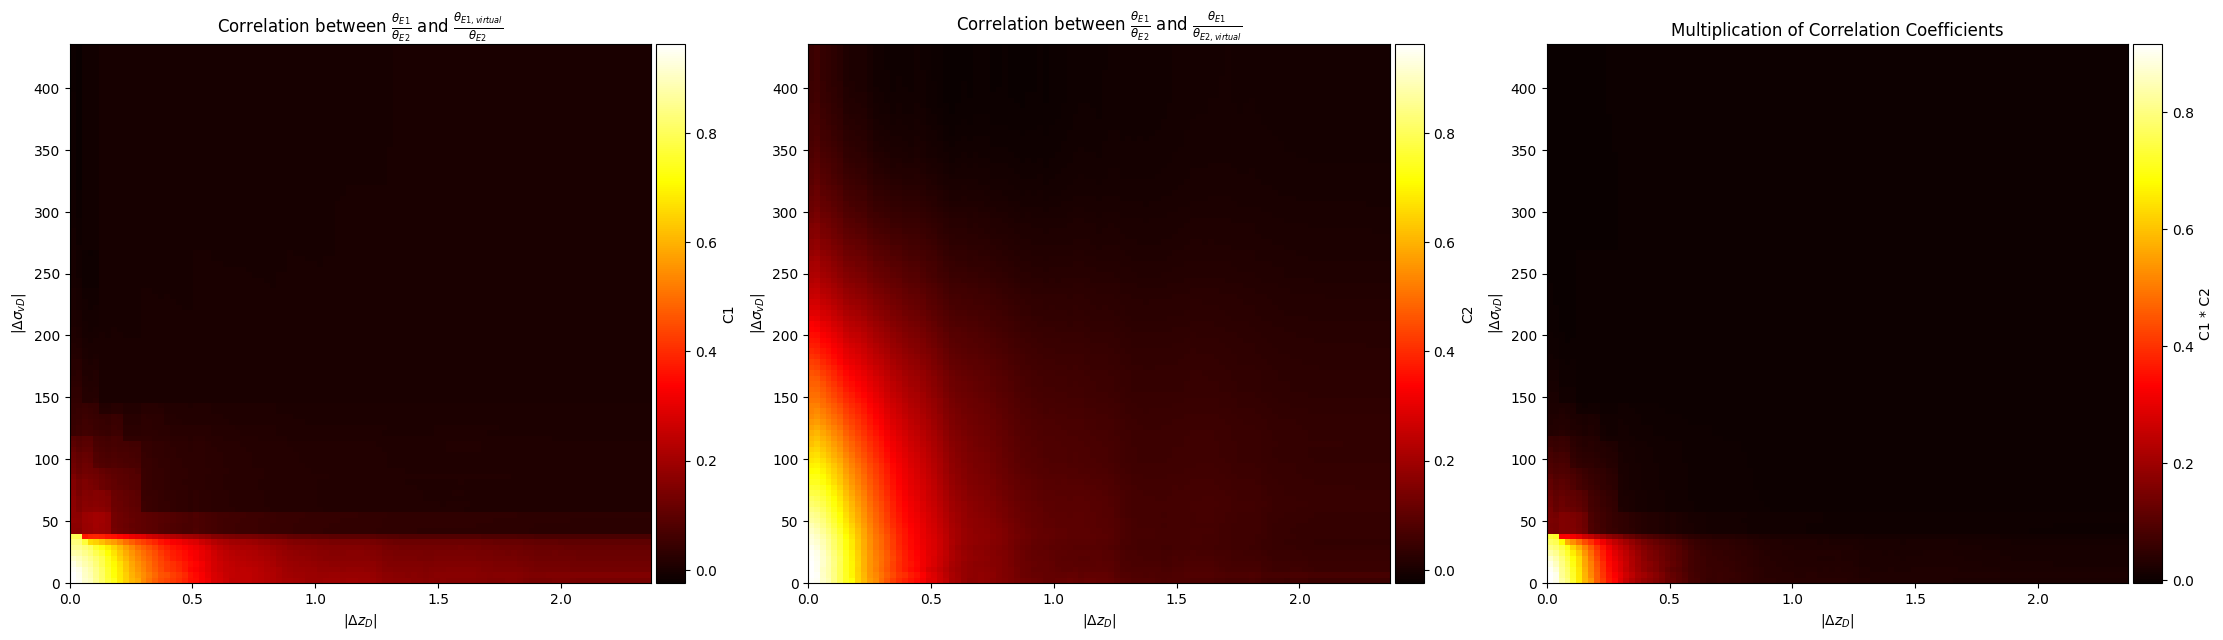

In [137]:
# 3. Then make a heatmap of the correlation and see how it varies with $|Δz_D|_i$ and $|Δσ_D|_j$.
fig, ax = plt.subplots(1, 3, figsize=(27, 7))
im = ax[0].imshow(
    correlations_1,
    origin="lower",
    aspect="auto",
    extent=[
        abs_delta_z_D_bins[0],
        abs_delta_z_D_bins[-1],
        abs_delta_sigma_v_D_bins[0],
        abs_delta_sigma_v_D_bins[-1],
    ],
    cmap="hot",
)
ax[0].set_xlabel(r"$|\Delta z_D|$")
ax[0].set_ylabel(r"$|\Delta \sigma_{vD}|$")
ax[0].set_title(
    r"Correlation between $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1, virtual}}{\theta_{E2}}$"
)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("C1")


ax[1].imshow(
    correlations_2,
    origin="lower",
    aspect="auto",
    extent=[
        abs_delta_z_D_bins[0],
        abs_delta_z_D_bins[-1],
        abs_delta_sigma_v_D_bins[0],
        abs_delta_sigma_v_D_bins[-1],
    ],
    cmap="hot",
)
ax[1].set_xlabel(r"$|\Delta z_D|$")
ax[1].set_ylabel(r"$|\Delta \sigma_{vD}|$")
ax[1].set_title(
    r"Correlation between $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1}}{\theta_{E2, virtual}}$"
)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("C2")

# multiplication of the two correlation coefficients
correlations = correlations_1 * correlations_2
im = ax[2].imshow(
    correlations,
    origin="lower",
    aspect="auto",
    extent=[
        abs_delta_z_D_bins[0],
        abs_delta_z_D_bins[-1],
        abs_delta_sigma_v_D_bins[0],
        abs_delta_sigma_v_D_bins[-1],
    ],
    cmap="hot",
)
ax[2].set_xlabel(r"$|\Delta z_D|$")
ax[2].set_ylabel(r"$|\Delta \sigma_{vD}|$")
ax[2].set_title(
    r"Multiplication of Correlation Coefficients"
)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("C1 * C2")

In [144]:
## zoom into the region with |Δz_D| < 0.5 and |Δσ_{vD}| < 60 km/s
## 1. Choose lenses with $|Δz_D| < |Δz_D|_i$ and $|Δσ_D| < |Δσ_D|_j$.
# make bins for $|Δz_D|$ and $|Δσ_D|$.

abs_delta_z_D_bins = np.linspace(
    np.min(filtered_pairing_parameters["abs_delta_z_D"]),
    0.5,
    100,
)
abs_delta_sigma_v_D_bins = np.linspace(
    np.min(filtered_pairing_parameters["abs_delta_sigma_v_D"]),
    60,
    100,
)

# 2. Estimate correlation between $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1, virtual}}{\theta_{E2}}$, or $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1}}{\theta_{E2, virtual}}$ for each $i, j$.
correlations_1 = np.zeros((len(abs_delta_z_D_bins) - 1, len(abs_delta_sigma_v_D_bins) - 1))
correlations_2 = np.zeros((len(abs_delta_z_D_bins) - 1, len(abs_delta_sigma_v_D_bins) - 1))
for i in range(len(abs_delta_z_D_bins) - 1):
    for j in range(len(abs_delta_sigma_v_D_bins) - 1):
        mask = (
            (filtered_pairing_parameters["abs_delta_z_D"] < abs_delta_z_D_bins[i+1])
            & (filtered_pairing_parameters["abs_delta_sigma_v_D"] < abs_delta_sigma_v_D_bins[j+1])
        )
        if np.sum(mask) > 0:
            correlations_1[i, j] = np.corrcoef(
                filtered_pairing_parameters["theta_E_ratio"][mask],
                filtered_pairing_parameters["theta_E1_by_theta_E2_virtual"][mask],
            )[0, 1]
            correlations_2[i, j] = np.corrcoef(
                filtered_pairing_parameters["theta_E_ratio"][mask],
                filtered_pairing_parameters["theta_E1_virtual_by_theta_E2"][mask],
            )[0, 1]
        else:
            correlations_1[i, j] = np.nan
            correlations_2[i, j] = np.nan

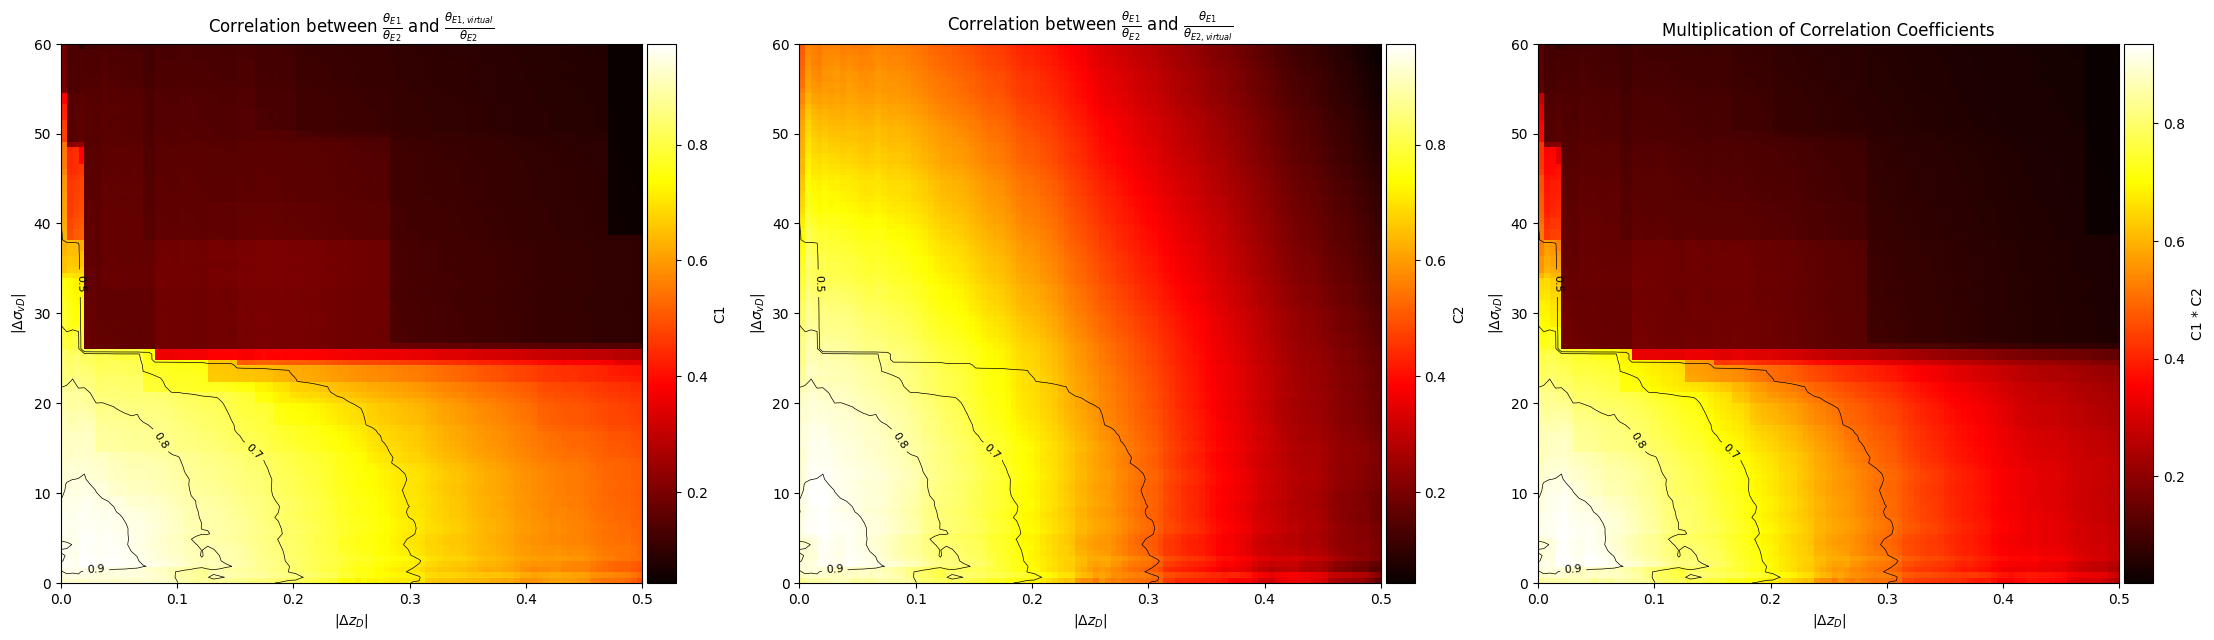

In [147]:
# 3. Then make a heatmap of the correlation and see how it varies with $|Δz_D|_i$ and $|Δσ_D|_j$.
fig, ax = plt.subplots(1, 3, figsize=(27, 7))
im = ax[0].imshow(
    correlations_1,
    origin="lower",
    aspect="auto",
    extent=[
        abs_delta_z_D_bins[0],
        abs_delta_z_D_bins[-1],
        abs_delta_sigma_v_D_bins[0],
        abs_delta_sigma_v_D_bins[-1],
    ],
    cmap="hot",
)
ax[0].set_xlabel(r"$|\Delta z_D|$")
ax[0].set_ylabel(r"$|\Delta \sigma_{vD}|$")
ax[0].set_title(
    r"Correlation between $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1, virtual}}{\theta_{E2}}$"
)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("C1")


ax[1].imshow(
    correlations_2,
    origin="lower",
    aspect="auto",
    extent=[
        abs_delta_z_D_bins[0],
        abs_delta_z_D_bins[-1],
        abs_delta_sigma_v_D_bins[0],
        abs_delta_sigma_v_D_bins[-1],
    ],
    cmap="hot",
)
ax[1].set_xlabel(r"$|\Delta z_D|$")
ax[1].set_ylabel(r"$|\Delta \sigma_{vD}|$")
ax[1].set_title(
    r"Correlation between $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1}}{\theta_{E2, virtual}}$"
)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("C2")

# multiplication of the two correlation coefficients
correlations = correlations_1 * correlations_2
im = ax[2].imshow(
    correlations,
    origin="lower",
    aspect="auto",
    extent=[
        abs_delta_z_D_bins[0],
        abs_delta_z_D_bins[-1],
        abs_delta_sigma_v_D_bins[0],
        abs_delta_sigma_v_D_bins[-1],
    ],
    cmap="hot",
)
ax[2].set_xlabel(r"$|\Delta z_D|$")
ax[2].set_ylabel(r"$|\Delta \sigma_{vD}|$")
ax[2].set_title(
    r"Multiplication of Correlation Coefficients"
)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("C1 * C2")


#contours

for ax_ in ax:
    ax_cs = ax_.contour(
        abs_delta_z_D_bins[:-1],
        abs_delta_sigma_v_D_bins[:-1],
        correlations,
        levels=[0.5, 0.7, 0.8, 0.9, 0.95],
        colors="k",
        linewidths=0.5,
    )
    ax_.clabel(
        ax_cs,
        inline=True,
        fontsize=8,
        fmt="%1.1f",
        colors="k",
        use_clabeltext=True,
    )

<a list of 4 text.Text objects>

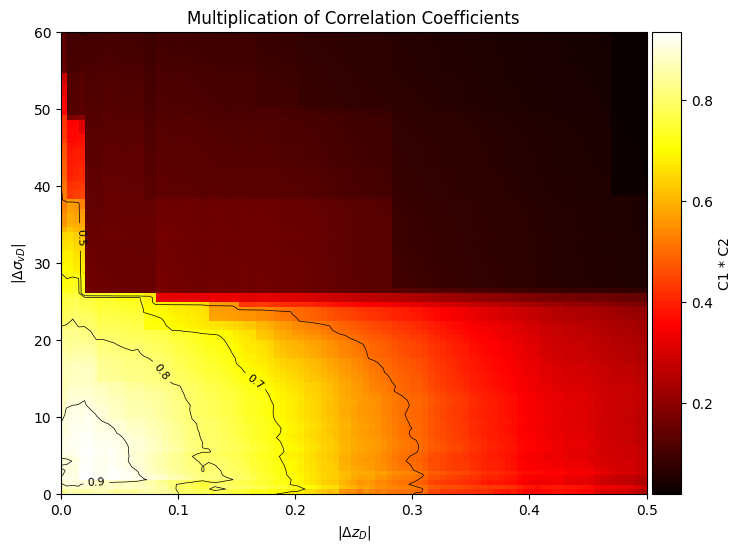

In [ ]:
correlations = correlations_1 * correlations_2

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
im = ax.imshow(
    correlations,
    origin="lower",
    aspect="auto",
    extent=[
        abs_delta_z_D_bins[0],
        abs_delta_z_D_bins[-1],
        abs_delta_sigma_v_D_bins[0],
        abs_delta_sigma_v_D_bins[-1],
    ],
    cmap="hot",
)
ax.set_xlabel(r"$|\Delta z_D|$")
ax.set_ylabel(r"$|\Delta \sigma_{vD}|$")
ax.set_title(
    r"Multiplication of Correlation Coefficients"
)
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 60)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("C1 * C2")

# contours
ax_cs = ax.contour(
    abs_delta_z_D_bins[:-1],
    abs_delta_sigma_v_D_bins[:-1],
    correlations,
    levels=[0.5, 0.7, 0.8, 0.9, 0.95],
    colors="k",
    linewidths=0.5,
)
plt.clabel(
    ax_cs,
    inline=True,
    fontsize=8,
    fmt="%1.1f",
    colors="k",
    use_clabeltext=True,
)

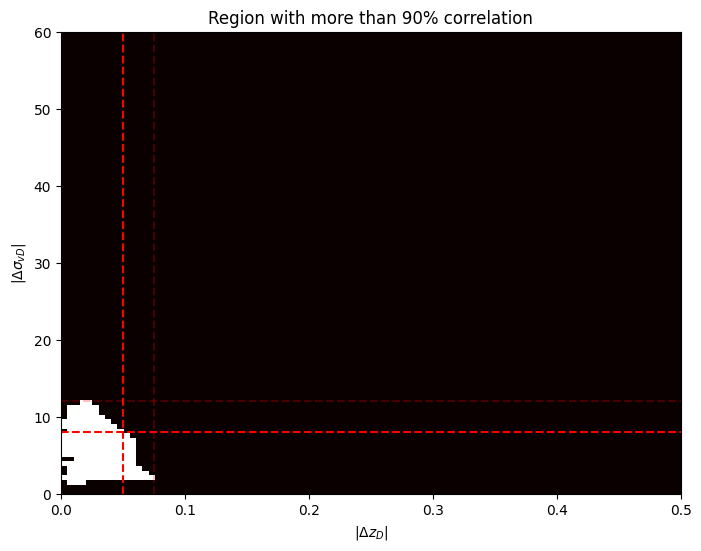

In [160]:
# region with more than 90% correlation
mask = correlations > 0.9
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
im = ax.imshow(
    mask,
    origin="lower",
    aspect="auto",
    extent=[
        abs_delta_z_D_bins[0],
        abs_delta_z_D_bins[-1],
        abs_delta_sigma_v_D_bins[0],
        abs_delta_sigma_v_D_bins[-1],
    ],
    cmap="hot",
)
ax.set_xlabel(r"$|\Delta z_D|$")
ax.set_ylabel(r"$|\Delta \sigma_{vD}|$")
ax.set_title(
    r"Region with more than 90% correlation"
)

# mark |Δz_D| < 0.05 and |Δσ_{vD}| < 10 km/s

ax.axhline(8, color="r", linestyle="--")
ax.axvline(0.05, color="r", linestyle="--")

ax.axhline(12, color="r", linestyle="--", alpha = 0.25)
ax.axvline(0.075, color="r", linestyle="--", alpha = 0.25)

So the region with more than 90% correlation is the best region to choose $|Δz_D|$ and $|Δσ_D|$. This roughly corresponds to $|Δz_D| < 0.05$ and $|Δσ_D| < 10$ km/s.

## YET ANOTHER WAY TO SET CRITERION

Algorithm for finding the best $|Δz_D|$ and $|Δσ_D|$ such that the pair can be treated as PDSPL!

1. Choose lenses with $|Δz_D|_i < |Δz_D| < |Δz_D|_{i+1}$ and $|Δσ_D|_j < |Δσ_D| < |Δσ_D|_{j+1}$.
2. Estimate correlation between $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1, virtual}}{\theta_{E2}}$, or $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1}}{\theta_{E2, virtual}}$ for each $i,j$.
3. Then make a heatmap of the correlation and see how it varies with $|Δz_D|_i$ and $|Δσ_D|_j$.
4. Choose the best $|Δz_D|$ and $|Δσ_D|$ such that the correlation is maximum.

In [165]:
## 1. Choose lenses with $|Δz_D| < |Δz_D|_i$ and $|Δσ_D| < |Δσ_D|_j$.
# make bins for $|Δz_D|$ and $|Δσ_D|$.

abs_delta_z_D_bins = np.linspace(
    np.min(filtered_pairing_parameters["abs_delta_z_D"]),
    np.max(filtered_pairing_parameters["abs_delta_z_D"]),
    100,
)
abs_delta_sigma_v_D_bins = np.linspace(
    np.min(filtered_pairing_parameters["abs_delta_sigma_v_D"]),
    np.max(filtered_pairing_parameters["abs_delta_sigma_v_D"]),
    100,
)

# 2. Estimate correlation between $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1, virtual}}{\theta_{E2}}$, or $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1}}{\theta_{E2, virtual}}$ for each $i, j$.
correlations_1 = np.zeros((len(abs_delta_z_D_bins) - 1, len(abs_delta_sigma_v_D_bins) - 1))
correlations_2 = np.zeros((len(abs_delta_z_D_bins) - 1, len(abs_delta_sigma_v_D_bins) - 1))
for i in range(len(abs_delta_z_D_bins) - 1):
    for j in range(len(abs_delta_sigma_v_D_bins) - 1):
        mask = (
            (filtered_pairing_parameters["abs_delta_z_D"] > abs_delta_z_D_bins[i])
            & (filtered_pairing_parameters["abs_delta_z_D"] < abs_delta_z_D_bins[i+1])
            & (filtered_pairing_parameters["abs_delta_sigma_v_D"] > abs_delta_sigma_v_D_bins[j])
            & (filtered_pairing_parameters["abs_delta_sigma_v_D"] < abs_delta_sigma_v_D_bins[j+1])
        )
        if np.sum(mask) > 0:
            correlations_1[i, j] = np.corrcoef(
                filtered_pairing_parameters["theta_E_ratio"][mask],
                filtered_pairing_parameters["theta_E1_by_theta_E2_virtual"][mask],
            )[0, 1]
            correlations_2[i, j] = np.corrcoef(
                filtered_pairing_parameters["theta_E_ratio"][mask],
                filtered_pairing_parameters["theta_E1_virtual_by_theta_E2"][mask],
            )[0, 1]
        else:
            correlations_1[i, j] = np.nan
            correlations_2[i, j] = np.nan

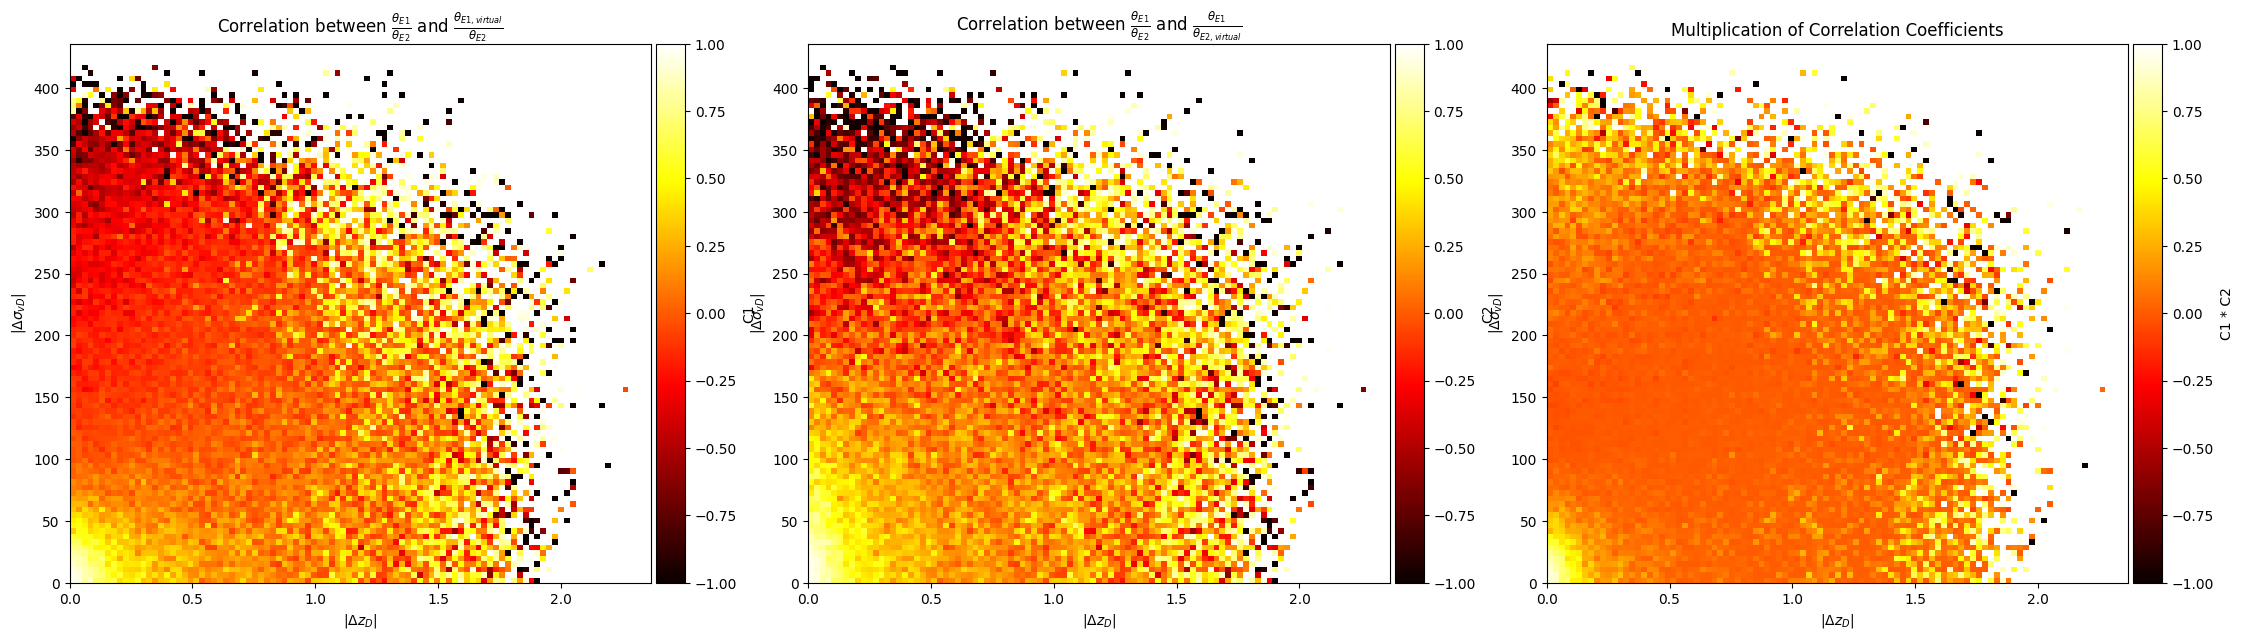

In [166]:
# 3. Then make a heatmap of the correlation and see how it varies with $|Δz_D|_i$ and $|Δσ_D|_j$.
fig, ax = plt.subplots(1, 3, figsize=(27, 7))
im = ax[0].imshow(
    correlations_1,
    origin="lower",
    aspect="auto",
    extent=[
        abs_delta_z_D_bins[0],
        abs_delta_z_D_bins[-1],
        abs_delta_sigma_v_D_bins[0],
        abs_delta_sigma_v_D_bins[-1],
    ],
    cmap="hot",
)
ax[0].set_xlabel(r"$|\Delta z_D|$")
ax[0].set_ylabel(r"$|\Delta \sigma_{vD}|$")
ax[0].set_title(
    r"Correlation between $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1, virtual}}{\theta_{E2}}$"
)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("C1")


ax[1].imshow(
    correlations_2,
    origin="lower",
    aspect="auto",
    extent=[
        abs_delta_z_D_bins[0],
        abs_delta_z_D_bins[-1],
        abs_delta_sigma_v_D_bins[0],
        abs_delta_sigma_v_D_bins[-1],
    ],
    cmap="hot",
)
ax[1].set_xlabel(r"$|\Delta z_D|$")
ax[1].set_ylabel(r"$|\Delta \sigma_{vD}|$")
ax[1].set_title(
    r"Correlation between $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1}}{\theta_{E2, virtual}}$"
)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("C2")

# multiplication of the two correlation coefficients
correlations = correlations_1 * correlations_2
im = ax[2].imshow(
    correlations,
    origin="lower",
    aspect="auto",
    extent=[
        abs_delta_z_D_bins[0],
        abs_delta_z_D_bins[-1],
        abs_delta_sigma_v_D_bins[0],
        abs_delta_sigma_v_D_bins[-1],
    ],
    cmap="hot",
)
ax[2].set_xlabel(r"$|\Delta z_D|$")
ax[2].set_ylabel(r"$|\Delta \sigma_{vD}|$")
ax[2].set_title(
    r"Multiplication of Correlation Coefficients"
)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("C1 * C2")

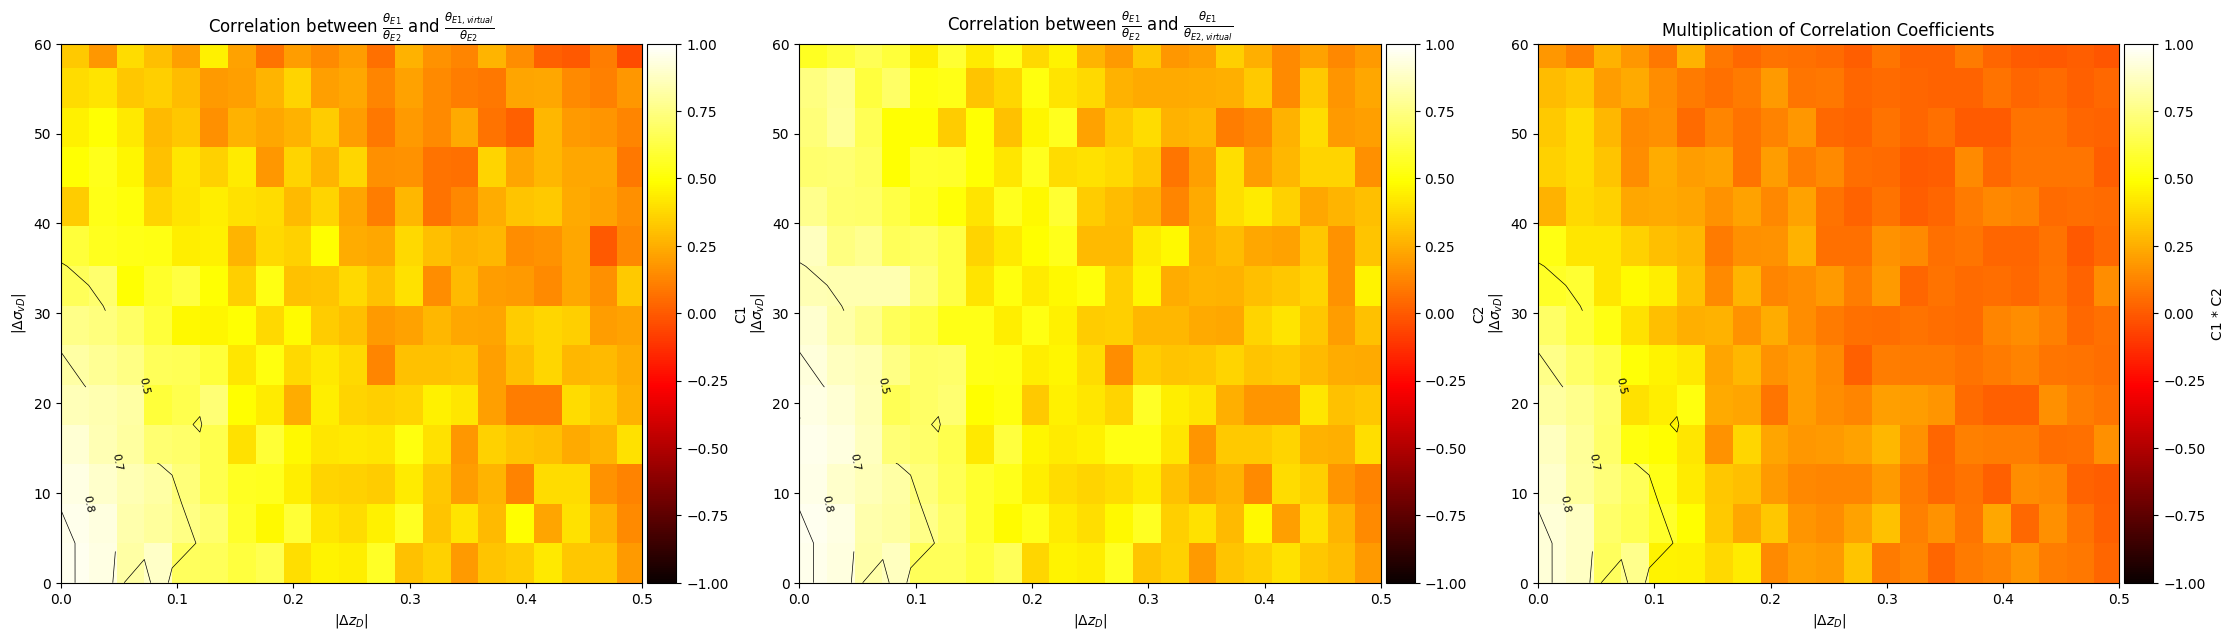

In [167]:
## zoom into the region with |Δz_D| < 0.5 and |Δσ_{vD}| < 60 km/s

# 3. Then make a heatmap of the correlation and see how it varies with $|Δz_D|_i$ and $|Δσ_D|_j$.
fig, ax = plt.subplots(1, 3, figsize=(27, 7))
im = ax[0].imshow(
    correlations_1,
    origin="lower",
    aspect="auto",
    extent=[
        abs_delta_z_D_bins[0],
        abs_delta_z_D_bins[-1],
        abs_delta_sigma_v_D_bins[0],
        abs_delta_sigma_v_D_bins[-1],
    ],
    cmap="hot",
)
ax[0].set_xlabel(r"$|\Delta z_D|$")
ax[0].set_ylabel(r"$|\Delta \sigma_{vD}|$")
ax[0].set_title(
    r"Correlation between $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1, virtual}}{\theta_{E2}}$"
)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("C1")


ax[1].imshow(
    correlations_2,
    origin="lower",
    aspect="auto",
    extent=[
        abs_delta_z_D_bins[0],
        abs_delta_z_D_bins[-1],
        abs_delta_sigma_v_D_bins[0],
        abs_delta_sigma_v_D_bins[-1],
    ],
    cmap="hot",
)
ax[1].set_xlabel(r"$|\Delta z_D|$")
ax[1].set_ylabel(r"$|\Delta \sigma_{vD}|$")
ax[1].set_title(
    r"Correlation between $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1}}{\theta_{E2, virtual}}$"
)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("C2")

# multiplication of the two correlation coefficients
correlations = correlations_1 * correlations_2
im = ax[2].imshow(
    correlations,
    origin="lower",
    aspect="auto",
    extent=[
        abs_delta_z_D_bins[0],
        abs_delta_z_D_bins[-1],
        abs_delta_sigma_v_D_bins[0],
        abs_delta_sigma_v_D_bins[-1],
    ],
    cmap="hot",
)
ax[2].set_xlabel(r"$|\Delta z_D|$")
ax[2].set_ylabel(r"$|\Delta \sigma_{vD}|$")
ax[2].set_title(
    r"Multiplication of Correlation Coefficients"
)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("C1 * C2")


#contours

for ax_ in ax:
    ax_cs = ax_.contour(
        abs_delta_z_D_bins[:-1],
        abs_delta_sigma_v_D_bins[:-1],
        correlations,
        levels=[0.5, 0.7, 0.8, 0.9, 0.95],
        colors="k",
        linewidths=0.5,
    )
    ax_.clabel(
        ax_cs,
        inline=True,
        fontsize=8,
        fmt="%1.1f",
        colors="k",
        use_clabeltext=True,
    )

    # set the x and y limits
    ax_.set_xlim(0, 0.5)
    ax_.set_ylim(0, 60)

<a list of 857 text.Text objects>

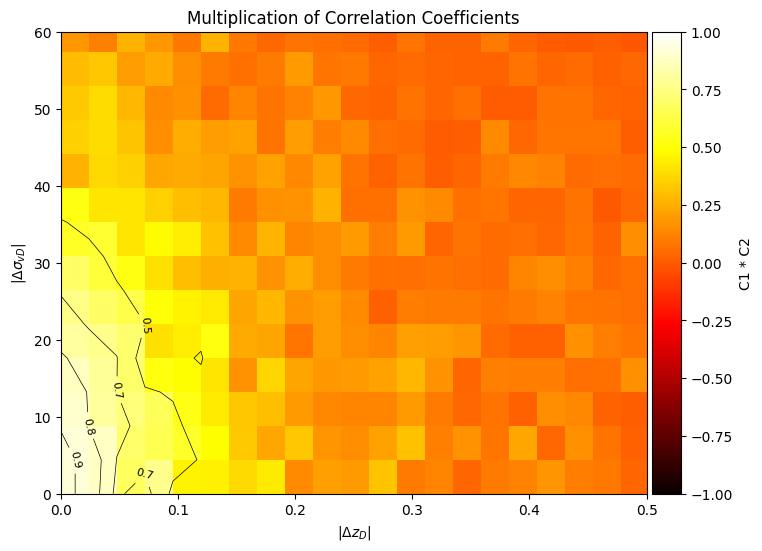

In [168]:
correlations = correlations_1 * correlations_2

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
im = ax.imshow(
    correlations,
    origin="lower",
    aspect="auto",
    extent=[
        abs_delta_z_D_bins[0],
        abs_delta_z_D_bins[-1],
        abs_delta_sigma_v_D_bins[0],
        abs_delta_sigma_v_D_bins[-1],
    ],
    cmap="hot",
)
ax.set_xlabel(r"$|\Delta z_D|$")
ax.set_ylabel(r"$|\Delta \sigma_{vD}|$")
ax.set_title(
    r"Multiplication of Correlation Coefficients"
)
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 60)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("C1 * C2")

# contours
ax_cs = ax.contour(
    abs_delta_z_D_bins[:-1],
    abs_delta_sigma_v_D_bins[:-1],
    correlations,
    levels=[0.5, 0.7, 0.8, 0.9, 0.95],
    colors="k",
    linewidths=0.5,
)
plt.clabel(
    ax_cs,
    inline=True,
    fontsize=8,
    fmt="%1.1f",
    colors="k",
    use_clabeltext=True,
)

So the region with more than 90% correlation is the best region to choose $|Δz_D|$ and $|Δσ_D|$. This roughly corresponds to $|Δz_D| < 0.05$ and $|Δσ_D| < 10$ km/s.